# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 100, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 100, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 100, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(100, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
#model.add(Conv2D(64, (3, 3), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))

model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(64,activation = 'relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 8, 32)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 4, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 2, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 1, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [23]:
keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [25]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])


In [26]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return 1e-3 -  2e-8* epoch

In [28]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 800,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/20
700/700 [==============================] - 3s 4ms/step - loss: 6.8699 - accuracy: 0.3507 - val_loss: 6.5447 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 2/20
700/700 [==============================] - 3s 4ms/step - loss: 6.6101 - accuracy: 0.3546 - val_loss: 6.1257 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 3/20
700/700 [==============================] - 3s 4ms/step - loss: 6.2998 - accuracy: 0.3597 - val_loss: 6.0072 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 4/20
700/700 [==============================] - 3s 4ms/step - loss: 6.1733 - accuracy: 0.3620 - val_loss: 5.8728 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 5/20
700/700 [==============================] - 3s 4ms/step - loss: 6.0264 - accuracy: 0.3651 - val_loss: 5.7072 - val_accuracy: 0.4060 - lr: 0.0010
Epoch 6/20
700/700 [==============================] - 3s 4ms/step - loss: 5.8615 - accuracy: 0.3707 - val_loss: 5.7703 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 7/20
700/700 [==============================] - 3s 4ms/step - lo

# Analizamos accuracy y loss

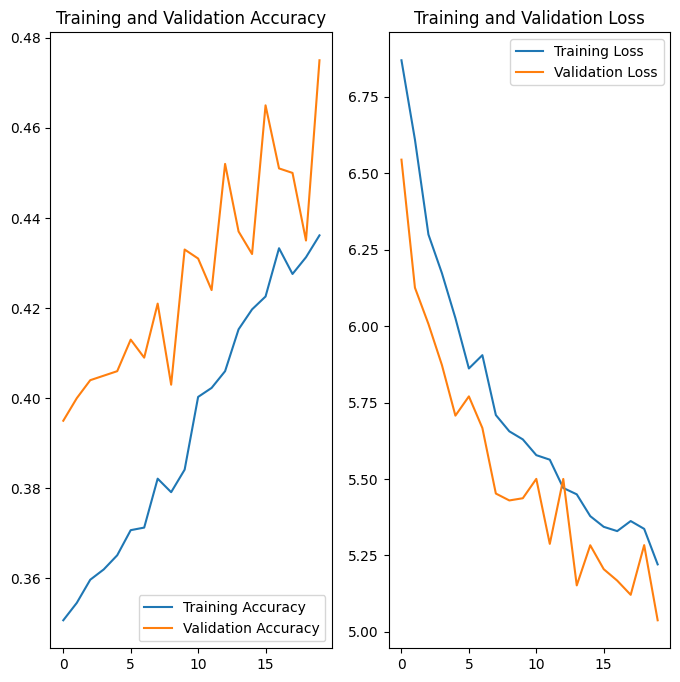

In [29]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [30]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 50,100/historyconvtrayec.csv', index=False)

# Guardamos el modelo

In [31]:
path_to_save = '../../../Modelos/Modelos 50,100/'

In [32]:
model.save(path_to_save + '/convolucionaltr.h5')

# Importamos el modelo

In [33]:
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 50,100/convolucionaltr.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [34]:
import random
from scipy.integrate import solve_ivp

varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)

    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])

        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
    contador = contador+1
    print(contador)

varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[8, 2, 0, 10, 7, 6, 4]
(10, 2, 100)
1


In [35]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [36]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 67ms/step
[[8.129093   2.3271677  0.42919415 4.925248   6.156442   7.401237
  2.8857615 ]]
[[8. 2. 0. 5. 6. 7. 3.]]


## Graficamos con los coeficientes reales

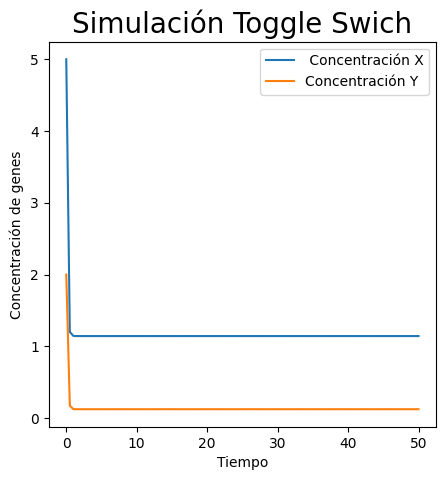

In [38]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
plt.figure(figsize=(5,5))
plt.plot(times,np.array(varf)[0,0,:], label=" Concentración X")
plt.plot(times,np.array(varf)[0,1,:], label="Concentración Y")
plt.xlabel('Tiempo')
plt.ylabel('Concentración de genes')
plt.title('Simulación Toggle Swich', fontsize=20)
plt.legend()
plt.show()

In [92]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

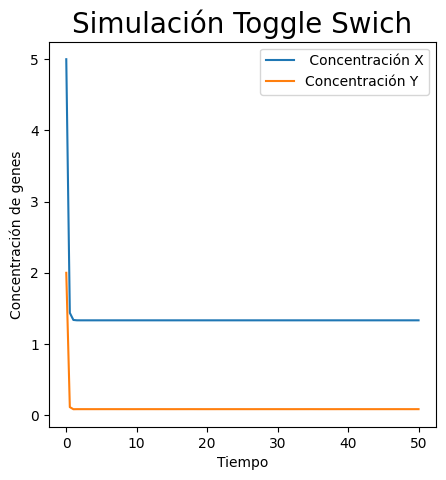

In [40]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)

# Definimos las condiciones iniciales
y0 = np.array([5,2])

# Resolvemos
# Modificar manualmente el intervalo de tiempo
sol = solve_ivp(f, t_span, y0, t_eval=times)
# sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
tiempo = sol.t
var1 = sol.y[0]
var2 = sol.y[1]

# Graficamos
plt.figure(figsize=(5, 5))
plt.plot(tiempo, var1, label=" Concentración X")
plt.plot(tiempo, var2, label="Concentración Y")
plt.xlabel('Tiempo')
plt.ylabel('Concentración de genes')
plt.title('Simulación Toggle Swich', fontsize=20)
plt.legend()
plt.show()